In [1]:
from importlib import reload
import fitsio as fio
import numpy as np
import pandas as pd

import healpy as hp
import copy
import sys
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.decomposition as decomp
import skysampler.emulator as emulator
import skysampler.indexer as indexer

import matplotlib as mpl
import subprocess as sp
import scipy.interpolate as interpolate
import pickle as pickle

import multiprocessing as mp

import skysampler.utils as utils


config read from file: /home/moon/vargatn/DES/Y3_WORK/skysampler-config/config/desy3-gamma-wide-config.yaml


In [2]:
def result_reader2(samples, scores, m_factor=20, nratio=1., seed=None):
    
    dc_score = np.exp(scores["dc"]) * np.abs(scores["dc_jac"])
    wr_score = np.exp(scores["wr"]) * np.abs(scores["wr_jac"])
    wcr_clust_score = np.exp(scores["wcr_clust"]) * np.abs(scores["wcr_clust_jac"])
    wcr_rands_score = np.exp(scores["wcr_rands"]) * np.abs(scores["wcr_rands_jac"])
#     fcls = fclfunc(samples["LOGR"]) - 1.
    
#     umult = np.max((fcls, np.ones(len(fcls))), axis=0)
#     print(umult)
    rng = np.random.RandomState(seed)
    uniform = rng.uniform(0, 1, len(samples)) #* umult
    
    p_proposal = m_factor * dc_score * wr_score
    p_rands_ref = wcr_rands_score
    p_clust_ref = wcr_clust_score #* fcls
    print(nratio)
    inds_field = (uniform < (p_rands_ref / nratio / p_proposal))
    inds_clust = ((p_rands_ref / nratio / p_proposal) < uniform) * (uniform < (p_clust_ref  / p_proposal))
    inds_2d = ((uniform < (p_clust_ref  / p_proposal)))

    return inds_field, inds_clust, inds_2d

In [3]:

tag_root = "des-dc2-alpha_concentric_sample-v02_test-01"
NREPEATS = 4
NSAMPLES = 1600000
NCHUNKS = 160
bandwidth=0.1

root_path = "/home/moon/vargatn/DES/PROJECTS/LSST/DATA/runs/"
deep_data_path = "/home/moon/vargatn/DES/PROJECTS/LSST/DATA/cosmoDC2_v1.1.4_refpixel_morepars-v2-8786.h5"
wide_clust_data_path = "/home/moon/vargatn/DES/PROJECTS/LSST/DATA/multi-indexer-epsilon_narrow-z_zoom_high-l_v004_clust_z0_l1_dict.p"
wide_rands_data_path = "/home/moon/vargatn/DES/PROJECTS/LSST/DATA/multi-indexer-epsilon_narrow-z_zoom_high-l_v004_rands_z0_l1_dict.p"

LOGR_DRAW_RMINS = np.array([-3, -0.5, 0., 0.5])
LOGR_DRAW_RMAXS = np.array([-0.5, 0., 0.5, 1.2])
LOGR_CAT_RMAXS = [0., 0.5, 1.1, 1.2]

deep_c_settings = {
    "columns": [
        ("MAG_I", "mag_i"),
        ("COLOR_G_R", ("mag_g", "mag_r", "-")),
        ("COLOR_R_I", ("mag_r", "mag_i", "-")),
    ],
    "logs": [False, False, False, False],
    "limits": [(17, 22.5), (-1, 3), (-1, 3), (-1, 3)],
}
deep_smc_settings = {
    "columns": [
        ("GABS", ("ellipticity_1_true", "ellipticity_2_true", "SQSUM")),
        ("SIZE", "size_true"),
        ("SIZE_MINOR", "size_minor_true"),
        ("SIZE_BULGE", "size_bulge_true"),
        ("SIZE_MINOR_BULGE", "size_minor_bulge_true"),
        ("SIZE_DISK", "size_disk_true"),
        ("SIZE_MINOR_DISK", "size_minor_disk_true"),
        ("MAG_I", "mag_i"),
        ("COLOR_G_R", ("mag_g", "mag_r", "-")),
        ("COLOR_R_I", ("mag_r", "mag_i", "-")),
        ("COLOR_I_Z", ("mag_i", "mag_z", "-")),
        ("STELLAR_MASS", "stellar_mass"),
    ],
    "logs": [False, True, True, True, True, True, True, False, False, False, False, True],
    "limits": [(0., 1.), (-1, 5), (-1, 5), (-1, 5), (-1, 5), (-1, 5), (-1, 5), (17, 25), (-1, 3), (-1, 3), (-1, 3), (10**3, 10**13)],
}

wide_cr_settings = {
    "columns": [
        ("MAG_I", "MOF_CM_MAG_CORRECTED_I"),
        ("COLOR_G_R", ("MOF_CM_MAG_CORRECTED_G", "MOF_CM_MAG_CORRECTED_R", "-")),
        ("COLOR_R_I", ("MOF_CM_MAG_CORRECTED_R", "MOF_CM_MAG_CORRECTED_I", "-")),
        ("LOGR", "DIST"),
    ],
    "logs": [False, False, False, True],
    "limits": [(17, 22.5), (-1, 3), (-1, 3), (1e-3, 50.), ],
}
wide_r_settings = {
    "columns": [
        ("MAG_I", "MOF_CM_MAG_CORRECTED_I"),
        ("LOGR", "DIST"),
    ],
    "logs": [False, True,],
    "limits": [(17, 22.5), (1e-3, 50.),],
}
columns = {
    "cols_dc": ["COLOR_G_R", "COLOR_R_I",],
    "cols_wr": ["LOGR",],
    "cols_wcr": ["COLOR_G_R", "COLOR_R_I", "LOGR",],
}

In [4]:
y3_ctab = pd.read_hdf("/home/moon/vargatn/DES/PROJECTS/LSST/DATA/multi-indexer-epsilon_narrow-z_zoom_high-l_v004_clust_z0_l1.h5")

Note: detected 160 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
Note: NumExpr detected 160 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


In [5]:
y3_rtab = pd.read_hdf("/home/moon/vargatn/DES/PROJECTS/LSST/DATA/multi-indexer-epsilon_narrow-z_zoom_high-l_v004_rands_z0_l1.h5")

In [6]:
print(wide_clust_data_path)
tmp = pickle.load(open(wide_clust_data_path, "rb"), encoding="latin1")
mdl_clust = indexer.IndexedDataContainer(**tmp)

print(wide_rands_data_path)
tmp = pickle.load(open(wide_rands_data_path, "rb"), encoding="latin1")
mdl_rands = indexer.IndexedDataContainer(**tmp)

print(deep_data_path)
refpixel = pd.read_hdf(deep_data_path, key="data")


/home/moon/vargatn/DES/PROJECTS/LSST/DATA/multi-indexer-epsilon_narrow-z_zoom_high-l_v004_clust_z0_l1_dict.p
/home/moon/vargatn/DES/PROJECTS/LSST/DATA/multi-indexer-epsilon_narrow-z_zoom_high-l_v004_rands_z0_l1_dict.p
/home/moon/vargatn/DES/PROJECTS/LSST/DATA/cosmoDC2_v1.1.4_refpixel_morepars-v2-8786.h5


In [7]:
tmp_wide_cr_settings = wide_cr_settings.copy()
_wide_cr_settings_rands = emulator.construct_wide_container(mdl_rands, tmp_wide_cr_settings, seed=1, drop="MAG_I")

# loading deep catalogs
_deep_c_settings = emulator.construct_deep_container(refpixel, deep_c_settings, seed=2, drop="MAG_I")
_deep_smc_settings = emulator.construct_deep_container(refpixel, deep_smc_settings, seed=3)

# loading cluster data
tmp_wide_cr_settings = wide_cr_settings.copy()
#             tmp_wide_cr_settings["limits"][-1] = (10**-3, 10**LOGR_CAT_RMAXS[i])
_wide_cr_settings_clust = emulator.construct_wide_container(mdl_clust, tmp_wide_cr_settings, seed=4, drop="MAG_I")

/home/moon/vargatn/DES/PROJECTS/skysampler/skysampler/emulator.py:158: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.alldata = pd.concat(np.array(self.samples)[valid_elements]).reset_index(drop=True)


(216060, 4)
(216060,)
(70310, 2)
(70310,)
(501640, 12)
(501640,)
(208230, 4)
(208230,)


In [24]:
hybrid_samples = []
hybrid_scores = []
for rbin in np.arange(4):
    print(rbin)
#     expr = "/e/ocean1/users/vargatn/EMULATOR/EPSILON/resamples/epsilon_concentric_sample_v06_run*_rbin" + str(rbin) + "*samples.fits" 
    expr = "/home/moon/vargatn/DES/PROJECTS/LSST/DATA/runs/des-dc2-alpha_concentric_sample-v02_test-01/des-dc2-alpha_concentric_sample-v02_test-01_run*_rbin{}*samples.fits".format(str(rbin))


    fnames_samples = np.sort(glob.glob(expr))
    fnames_scores = []
    for fname in fnames_samples:
        fnames_scores.append(fname.replace("samples.fits", "scores.fits"))

    samples_sep = []
    scores_sep = []
    for i, fname in enumerate(fnames_samples):
#         print(fname)
        samples_sep.append(fio.read(fname))
        scores_sep.append(fio.read(fnames_scores[i]))
        
    hybrid_samples.append(np.hstack(samples_sep))
    hybrid_scores.append(np.hstack(scores_sep))

0
1
2
3


In [25]:
mag_lims = (17, 22.5)
r_lims_all = [(-1.5, -0.5), (-0.5, 0.), (0, 0.5), (0.5, 1.0)]
redges = [-1.5, -0.5, 0., 0.5, 1.0]
rareas = np.array([np.pi*((10**redges[i+1])**2. - (10**redges[i])**2.) for i in np.arange(len(redges)-1)])

In [26]:
nc = 123
nr = 500

In [27]:
magcol = "MAG_I"
ii = ((y3_ctab[magcol] > mag_lims[0]) & (y3_ctab[magcol] < mag_lims[1]))
clust_los_nums = np.histogram(y3_ctab[ii]["LOGR"], weights=y3_ctab[ii]["WEIGHTS"], bins=redges)[0] / nc
ii = ((y3_rtab[magcol] > mag_lims[0]) & (y3_rtab[magcol] < mag_lims[1]))
rands_los_nums = np.histogram(y3_rtab[ii]["LOGR"], weights=y3_rtab[ii]["WEIGHTS"], bins=redges)[0] / nr
y3_nratios = clust_los_nums / rands_los_nums

In [28]:
hybrid_ifields2 = []
hybrid_iclusts2 = []
hybrid_i2ds2 = []
for rbin in np.arange(4):
    print(rbin)
    _ifield, _iclust, _i2d = result_reader2(hybrid_samples[rbin], hybrid_scores[rbin], nratio=y3_nratios[rbin], m_factor=100, seed=rbin)
    hybrid_ifields2.append(_ifield)
    hybrid_iclusts2.append(_iclust)
    hybrid_i2ds2.append(_i2d)

0
3.7455659109436623
1
2.4819160870030195
2
1.3948185773196122
3
1.0611671167284917


In [29]:
hybrid_csamples = []
for rbin in np.arange(4):
    print(rbin)
    tab = pd.DataFrame.from_records(hybrid_samples[rbin][hybrid_iclusts2[rbin]].byteswap().newbyteorder())
    tab.drop('index', axis=1, inplace=True)
    kde = emulator.KDEContainer(tab)
    kde.standardize_data()
    kde.construct_kde(0.01)
    _csample = kde.random_draw(4e6)
    hybrid_csamples.append(_csample)

0
1
2
3


In [30]:
hybrid_rsamples = []
for rbin in np.arange(4):
    print(rbin)
    tab = pd.DataFrame.from_records(hybrid_samples[rbin][hybrid_ifields2[rbin]].byteswap().newbyteorder())
    tab.drop('index', axis=1, inplace=True)
    kde = emulator.KDEContainer(tab)
    kde.standardize_data()
    kde.construct_kde(0.01)
    _rsample = kde.random_draw(4e6)
    hybrid_rsamples.append(_rsample)

0
1
2
3


In [31]:
hybrid_allsamples = []
for rbin in np.arange(4):
    print(rbin)
    tab = pd.DataFrame.from_records(hybrid_samples[rbin][hybrid_i2ds2[rbin]].byteswap().newbyteorder())
    tab.drop('index', axis=1, inplace=True)
    kde = emulator.KDEContainer(tab)
    kde.standardize_data()
    kde.construct_kde(0.01)
    _sample = kde.random_draw(4e6)
    hybrid_allsamples.append(_sample)

0
1
2
3


In [32]:
def tohist(edges, vals):
    arr = []
    res = []
    for i in np.arange(len(vals)):
        arr.append(edges[i])
        arr.append(edges[i + 1])
        res.append(vals[i])
        res.append(vals[i])
    return arr, res

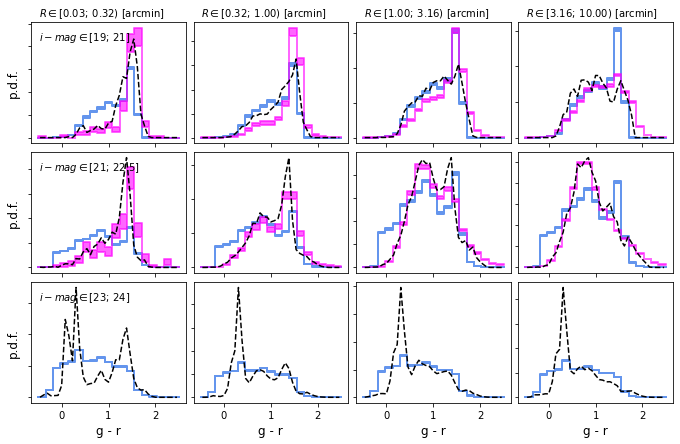

In [33]:
fig, axarr = plt.subplots(nrows=3, ncols=4, figsize=(11.5, 7.), sharex=False, sharey=False)
fig.subplots_adjust(hspace=0.075, wspace=0.05)

bins_hist = np.linspace(-0.5, 2.5, 20)
cens_hist = bins_hist[:-1] + np.diff(bins_hist) / 2
bins_kde = np.linspace(-0.5, 2.5, 40)
cens = bins_kde[:-1] + np.diff(bins_kde) / 2

for ax in axarr[0]:
    ax.set_xticklabels([])
for ax in axarr[1]:
    ax.set_xticklabels([])    

for ax in axarr[:, 0]:
    ax.set_yticklabels([])
    
for ax in axarr[0, 1:]:
    ax.set_yticklabels([])
for ax in axarr[1, 1:]:
    ax.set_yticklabels([])
for ax in axarr[2, 1:]:
    ax.set_yticklabels([])    
        
for ax in axarr[2]:
    ax.set_xlabel("g - r", fontsize=12)
for ax in axarr[:, 0]:
    ax.set_ylabel("p.d.f.", fontsize=12)
    
col = "COLOR_G_R" 
magcol = "MAG_I"
rcol = "LOGR"

r_lims_all = [(-1.5, -0.5), (-0.5, 0.), (0, 0.5), (0.5, 1.0)]

# ####################################################################################################
mag_lims = (19., 21.)
for rbin in np.arange(4):
    ax = axarr[0, rbin]

    r_lims = r_lims_all[rbin]
    sample = _deep_smc_settings["container"].data
#     csample = csamples[rbin]
#     rsample = rsamples[rbin]

    ax.text(0.05, 1.05,"$R \in[{:.2f};\,{:.2f})$ [arcmin]".format(10**r_lims[0], 10**r_lims[1]),
            transform=ax.transAxes, fontsize=10)  
        

#     ctab = _dc2_wide_cr_settings_clust["container"].data.copy()
#     ii = ((ctab[magcol] > mag_lims[0]) & (ctab[magcol] < mag_lims[1]) &
#           (ctab[rcol] > r_lims[0]) & (ctab[rcol] < r_lims[1]))
#     counts = np.histogram(ctab[ii][col], bins=bins_hist)[0]    
#     c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
#     c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
#     counts = counts / (counts * np.diff(bins_hist)).sum()
#     edges, v16 = tohist(bins_hist, c16)
#     edges, v84 = tohist(bins_hist, c84)
#     ax.fill_between(edges, v16, v84, color="orange", label="DC2", lw=2, alpha=0.6)    
    
    
    ii = (sample[magcol] > mag_lims[0]) & (sample[magcol] < mag_lims[1])
    counts = np.histogram(sample[ii][col], bins=bins_hist)[0]
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="cornflowerblue", lw=2, label="field")     
    
    ctab = y3_ctab
    ii = ((ctab[magcol] > mag_lims[0]) & (ctab[magcol] < mag_lims[1]) &
          (ctab[rcol] > r_lims[0]) & (ctab[rcol] < r_lims[1]))
    counts = np.histogram(ctab[ii][col], bins=bins_hist)[0]    
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="magenta", label="Y3", lw=2, alpha=0.6)        


    
    allsample = hybrid_allsamples[rbin]
    ii = ((allsample[magcol] > mag_lims[0]) & (allsample[magcol] < mag_lims[1]) &
          (allsample[rcol] > r_lims[0]) & (allsample[rcol] < r_lims[1]))
    counts = np.histogram(allsample[ii][col], bins=bins_kde, density=True)[0]    
    ax.plot(cens, counts, ls="--", color="black", lw=1.5, label="LOS model")   
    
#     allsample = y3_allsamples[rbin]
#     ii = ((allsample[magcol] > mag_lims[0]) & (allsample[magcol] < mag_lims[1]) &
#           (allsample[rcol] > r_lims[0]) & (allsample[rcol] < r_lims[1]))
#     counts = np.histogram(allsample[ii][col], bins=bins_kde, density=True)[0]    
#     ax.plot(cens, counts, ls="--", color="red", lw=1.5, label="LOS model")         
    
# # ####################################################################################################
mag_lims = (21., 22.5)
for rbin in np.arange(4):
    ax = axarr[1, rbin]

    r_lims = r_lims_all[rbin]
    sample = _deep_smc_settings["container"].data
#     csample = csamples[rbin]
#     rsample = rsamples[rbin]

#     ctab = _dc2_wide_cr_settings_clust["container"].data.copy()
#     ii = ((ctab[magcol] > mag_lims[0]) & (ctab[magcol] < mag_lims[1]) &
#           (ctab[rcol] > r_lims[0]) & (ctab[rcol] < r_lims[1]))
#     counts = np.histogram(ctab[ii][col], bins=bins_hist)[0]    
#     c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
#     c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
#     counts = counts / (counts * np.diff(bins_hist)).sum()
#     edges, v16 = tohist(bins_hist, c16)
#     edges, v84 = tohist(bins_hist, c84)
#     ax.fill_between(edges, v16, v84, color="orange", label="DC2 LOS", lw=2, alpha=0.6)  
    
    ii = (sample[magcol] > mag_lims[0]) & (sample[magcol] < mag_lims[1])
    counts = np.histogram(sample[ii][col], bins=bins_hist)[0]
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="cornflowerblue", lw=2, label="field")     
    
    allsample = hybrid_allsamples[rbin]
    ii = ((allsample[magcol] > mag_lims[0]) & (allsample[magcol] < mag_lims[1]) &
          (allsample[rcol] > r_lims[0]) & (allsample[rcol] < r_lims[1]))
    counts = np.histogram(allsample[ii][col], bins=bins_kde, density=True)[0]    
    ax.plot(cens, counts, ls="--", color="black", lw=1.5, label="DC2 model")       
        
    ctab = y3_ctab
    ii = ((ctab[magcol] > mag_lims[0]) & (ctab[magcol] < mag_lims[1]) &
          (ctab[rcol] > r_lims[0]) & (ctab[rcol] < r_lims[1]))
    counts = np.histogram(ctab[ii][col], bins=bins_hist)[0]    
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="magenta", label="Y3 LOS", lw=2, alpha=0.6)        
        

#     allsample = y3_allsamples[rbin]
#     ii = ((allsample[magcol] > mag_lims[0]) & (allsample[magcol] < mag_lims[1]) &
#           (allsample[rcol] > r_lims[0]) & (allsample[rcol] < r_lims[1]))
#     counts = np.histogram(allsample[ii][col], bins=bins_kde, density=True)[0]    
#     ax.plot(cens, counts, ls="--", color="red", lw=1.5, label="Y3 model")            
#     handles, labels = ax.get_legend_handles_labels()    

# # ####################################################################################################
mag_lims = (23., 24)
for rbin in np.arange(4):
    ax = axarr[2, rbin]

    r_lims = r_lims_all[rbin]
    sample = _deep_smc_settings["container"].data
#     csample = csamples[rbin]
#     rsample = rsamples[rbin]
   
    
#     ctab = _dc2_wide_cr_settings_clust["container"].data.copy()
#     ii = ((ctab[magcol] > mag_lims[0]) & (ctab[magcol] < mag_lims[1]) &
#           (ctab[rcol] > r_lims[0]) & (ctab[rcol] < r_lims[1]))
#     counts = np.histogram(ctab[ii][col], bins=bins_hist)[0]    
#     c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
#     c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
#     counts = counts / (counts * np.diff(bins_hist)).sum()
#     edges, v16 = tohist(bins_hist, c16)
#     edges, v84 = tohist(bins_hist, c84)
#     ax.fill_between(edges, v16, v84, color="orange", label="Cluster LOS", lw=2, alpha=0.6)    
    
    ii = (sample[magcol] > mag_lims[0]) & (sample[magcol] < mag_lims[1])
    counts = np.histogram(sample[ii][col], bins=bins_hist)[0]
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="cornflowerblue", lw=2, label="field")         
    
    allsample = hybrid_allsamples[rbin]
    ii = ((allsample[magcol] > mag_lims[0]) & (allsample[magcol] < mag_lims[1]) &
          (allsample[rcol] > r_lims[0]) & (allsample[rcol] < r_lims[1]))
    counts = np.histogram(allsample[ii][col], bins=bins_kde, density=True)[0]    
    ax.plot(cens, counts, ls="--", color="black", lw=1.5, label="LOS model")     
    
#     allsample = y3_allsamples[rbin]
#     ii = ((allsample[magcol] > mag_lims[0]) & (allsample[magcol] < mag_lims[1]) &
#           (allsample[rcol] > r_lims[0]) & (allsample[rcol] < r_lims[1]))
#     counts = np.histogram(allsample[ii][col], bins=bins_kde, density=True)[0]    
#     ax.plot(cens, counts, ls="--", color="red", lw=1.5, label="LOS model")        

    
fs = 10

# axarr[2, 3].legend(loc=3, fontsize=fs, handles=handles, labels=labels)    
    

# axarr[2, 0].text(0.05, 0.72, "Depth Extrapolation", transform=axarr[2, 0].transAxes, fontsize=fs)
# axarr[0, 0].text(0.05, 0.63, "$\lambda\in[30;\,60)$", transform=axarr[0, 0].transAxes, fontsize=fs)
# axarr[0, 0].text(0.05, 0.51, "$z\in[0.3;\,0.35)$", transform=axarr[0, 0].transAxes, fontsize=fs)

axarr[0, 0].text(0.05, 0.85, "$i-mag\in[19;\, 21]$", transform=axarr[0, 0].transAxes, fontsize=fs)
axarr[1, 0].text(0.05, 0.85, "$i-mag\in[21;\, 22.5]$", transform=axarr[1, 0].transAxes, fontsize=fs)
axarr[2, 0].text(0.05, 0.85, "$i-mag\in[23;\, 24]$ ", transform=axarr[2, 0].transAxes, fontsize=fs)
# axarr[2, 0].text(0.05, 0.73, "Depth Extrapolation".upper(), transform=axarr[2, 0].transAxes, fontsize=fs, color="red")
# fig.text(0.13, 0.95, "DC2 redmapper clusters Emulator model", fontsize=14)
fig.savefig("Hybrid-DC2xY3-ALPHA_LOWZ_decoupled_g-r-color_magnitude_slices_radial_v01.png", dpi=300, bbox_inches="tight")

Text(0.05, 0.85, '$i-mag\\in[23;\\, 24]$ ')

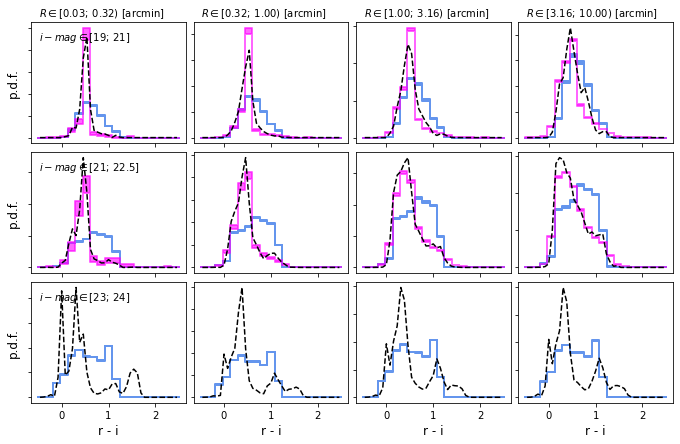

In [34]:
fig, axarr = plt.subplots(nrows=3, ncols=4, figsize=(11.5, 7.), sharex=False, sharey=False)
fig.subplots_adjust(hspace=0.075, wspace=0.05)

bins_hist = np.linspace(-0.5, 2.5, 20)
cens_hist = bins_hist[:-1] + np.diff(bins_hist) / 2
bins_kde = np.linspace(-0.5, 2.5, 40)
cens = bins_kde[:-1] + np.diff(bins_kde) / 2

for ax in axarr[0]:
    ax.set_xticklabels([])
for ax in axarr[1]:
    ax.set_xticklabels([])    

for ax in axarr[:, 0]:
    ax.set_yticklabels([])
    
for ax in axarr[0, 1:]:
    ax.set_yticklabels([])
for ax in axarr[1, 1:]:
    ax.set_yticklabels([])
for ax in axarr[2, 1:]:
    ax.set_yticklabels([])    
        
for ax in axarr[2]:
    ax.set_xlabel("r - i", fontsize=12)
for ax in axarr[:, 0]:
    ax.set_ylabel("p.d.f.", fontsize=12)
    
col = "COLOR_R_I" 
magcol = "MAG_I"
rcol = "LOGR"

r_lims_all = [(-1.5, -0.5), (-0.5, 0.), (0, 0.5), (0.5, 1.0)]

# ####################################################################################################
mag_lims = (19., 21.)
for rbin in np.arange(4):
    ax = axarr[0, rbin]

    r_lims = r_lims_all[rbin]
    sample = _deep_smc_settings["container"].data
#     csample = csamples[rbin]
#     rsample = rsamples[rbin]

    ax.text(0.05, 1.05,"$R \in[{:.2f};\,{:.2f})$ [arcmin]".format(10**r_lims[0], 10**r_lims[1]),
            transform=ax.transAxes, fontsize=10)  
        

#     ctab = _dc2_wide_cr_settings_clust["container"].data.copy()
#     ii = ((ctab[magcol] > mag_lims[0]) & (ctab[magcol] < mag_lims[1]) &
#           (ctab[rcol] > r_lims[0]) & (ctab[rcol] < r_lims[1]))
#     counts = np.histogram(ctab[ii][col], bins=bins_hist)[0]    
#     c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
#     c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
#     counts = counts / (counts * np.diff(bins_hist)).sum()
#     edges, v16 = tohist(bins_hist, c16)
#     edges, v84 = tohist(bins_hist, c84)
#     ax.fill_between(edges, v16, v84, color="orange", label="DC2", lw=2, alpha=0.6)    
    
    
    ii = (sample[magcol] > mag_lims[0]) & (sample[magcol] < mag_lims[1])
    counts = np.histogram(sample[ii][col], bins=bins_hist)[0]
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="cornflowerblue", lw=2, label="field")     
    
    ctab = y3_ctab
    ii = ((ctab[magcol] > mag_lims[0]) & (ctab[magcol] < mag_lims[1]) &
          (ctab[rcol] > r_lims[0]) & (ctab[rcol] < r_lims[1]))
    counts = np.histogram(ctab[ii][col], bins=bins_hist)[0]    
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="magenta", label="Y3", lw=2, alpha=0.6)        


    
    allsample = hybrid_allsamples[rbin]
    ii = ((allsample[magcol] > mag_lims[0]) & (allsample[magcol] < mag_lims[1]) &
          (allsample[rcol] > r_lims[0]) & (allsample[rcol] < r_lims[1]))
    counts = np.histogram(allsample[ii][col], bins=bins_kde, density=True)[0]    
    ax.plot(cens, counts, ls="--", color="black", lw=1.5, label="LOS model")   
    
#     allsample = y3_allsamples[rbin]
#     ii = ((allsample[magcol] > mag_lims[0]) & (allsample[magcol] < mag_lims[1]) &
#           (allsample[rcol] > r_lims[0]) & (allsample[rcol] < r_lims[1]))
#     counts = np.histogram(allsample[ii][col], bins=bins_kde, density=True)[0]    
#     ax.plot(cens, counts, ls="--", color="red", lw=1.5, label="LOS model")         
    
# # ####################################################################################################
mag_lims = (21., 22.5)
for rbin in np.arange(4):
    ax = axarr[1, rbin]

    r_lims = r_lims_all[rbin]
    sample = _deep_smc_settings["container"].data
#     csample = csamples[rbin]
#     rsample = rsamples[rbin]

#     ctab = _dc2_wide_cr_settings_clust["container"].data.copy()
#     ii = ((ctab[magcol] > mag_lims[0]) & (ctab[magcol] < mag_lims[1]) &
#           (ctab[rcol] > r_lims[0]) & (ctab[rcol] < r_lims[1]))
#     counts = np.histogram(ctab[ii][col], bins=bins_hist)[0]    
#     c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
#     c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
#     counts = counts / (counts * np.diff(bins_hist)).sum()
#     edges, v16 = tohist(bins_hist, c16)
#     edges, v84 = tohist(bins_hist, c84)
#     ax.fill_between(edges, v16, v84, color="orange", label="DC2 LOS", lw=2, alpha=0.6)  
    
    ii = (sample[magcol] > mag_lims[0]) & (sample[magcol] < mag_lims[1])
    counts = np.histogram(sample[ii][col], bins=bins_hist)[0]
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="cornflowerblue", lw=2, label="field")     
    
    allsample = hybrid_allsamples[rbin]
    ii = ((allsample[magcol] > mag_lims[0]) & (allsample[magcol] < mag_lims[1]) &
          (allsample[rcol] > r_lims[0]) & (allsample[rcol] < r_lims[1]))
    counts = np.histogram(allsample[ii][col], bins=bins_kde, density=True)[0]    
    ax.plot(cens, counts, ls="--", color="black", lw=1.5, label="DC2 model")       
        
    ctab = y3_ctab
    ii = ((ctab[magcol] > mag_lims[0]) & (ctab[magcol] < mag_lims[1]) &
          (ctab[rcol] > r_lims[0]) & (ctab[rcol] < r_lims[1]))
    counts = np.histogram(ctab[ii][col], bins=bins_hist)[0]    
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="magenta", label="Y3 LOS", lw=2, alpha=0.6)        
        

#     allsample = y3_allsamples[rbin]
#     ii = ((allsample[magcol] > mag_lims[0]) & (allsample[magcol] < mag_lims[1]) &
#           (allsample[rcol] > r_lims[0]) & (allsample[rcol] < r_lims[1]))
#     counts = np.histogram(allsample[ii][col], bins=bins_kde, density=True)[0]    
#     ax.plot(cens, counts, ls="--", color="red", lw=1.5, label="Y3 model")            
#     handles, labels = ax.get_legend_handles_labels()    

# # ####################################################################################################
mag_lims = (23., 24)
for rbin in np.arange(4):
    ax = axarr[2, rbin]

    r_lims = r_lims_all[rbin]
    sample = _deep_smc_settings["container"].data
#     csample = csamples[rbin]
#     rsample = rsamples[rbin]
   
    
#     ctab = _dc2_wide_cr_settings_clust["container"].data.copy()
#     ii = ((ctab[magcol] > mag_lims[0]) & (ctab[magcol] < mag_lims[1]) &
#           (ctab[rcol] > r_lims[0]) & (ctab[rcol] < r_lims[1]))
#     counts = np.histogram(ctab[ii][col], bins=bins_hist)[0]    
#     c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
#     c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
#     counts = counts / (counts * np.diff(bins_hist)).sum()
#     edges, v16 = tohist(bins_hist, c16)
#     edges, v84 = tohist(bins_hist, c84)
#     ax.fill_between(edges, v16, v84, color="orange", label="Cluster LOS", lw=2, alpha=0.6)    
    
    ii = (sample[magcol] > mag_lims[0]) & (sample[magcol] < mag_lims[1])
    counts = np.histogram(sample[ii][col], bins=bins_hist)[0]
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="cornflowerblue", lw=2, label="field")         
    
    allsample = hybrid_allsamples[rbin]
    ii = ((allsample[magcol] > mag_lims[0]) & (allsample[magcol] < mag_lims[1]) &
          (allsample[rcol] > r_lims[0]) & (allsample[rcol] < r_lims[1]))
    counts = np.histogram(allsample[ii][col], bins=bins_kde, density=True)[0]    
    ax.plot(cens, counts, ls="--", color="black", lw=1.5, label="LOS model")     
    
#     allsample = y3_allsamples[rbin]
#     ii = ((allsample[magcol] > mag_lims[0]) & (allsample[magcol] < mag_lims[1]) &
#           (allsample[rcol] > r_lims[0]) & (allsample[rcol] < r_lims[1]))
#     counts = np.histogram(allsample[ii][col], bins=bins_kde, density=True)[0]    
#     ax.plot(cens, counts, ls="--", color="red", lw=1.5, label="LOS model")        

    
fs = 10

# axarr[2, 3].legend(loc=3, fontsize=fs, handles=handles, labels=labels)    
    

# axarr[2, 0].text(0.05, 0.72, "Depth Extrapolation", transform=axarr[2, 0].transAxes, fontsize=fs)
# axarr[0, 0].text(0.05, 0.63, "$\lambda\in[30;\,60)$", transform=axarr[0, 0].transAxes, fontsize=fs)
# axarr[0, 0].text(0.05, 0.51, "$z\in[0.3;\,0.35)$", transform=axarr[0, 0].transAxes, fontsize=fs)

axarr[0, 0].text(0.05, 0.85, "$i-mag\in[19;\, 21]$", transform=axarr[0, 0].transAxes, fontsize=fs)
axarr[1, 0].text(0.05, 0.85, "$i-mag\in[21;\, 22.5]$", transform=axarr[1, 0].transAxes, fontsize=fs)
axarr[2, 0].text(0.05, 0.85, "$i-mag\in[23;\, 24]$ ", transform=axarr[2, 0].transAxes, fontsize=fs)
# axarr[2, 0].text(0.05, 0.73, "Depth Extrapolation".upper(), transform=axarr[2, 0].transAxes, fontsize=fs, color="red")
# fig.text(0.13, 0.95, "DC2 redmapper clusters Emulator model", fontsize=14)
# fig.savefig("Hybrid-DC2xY3-ALPHA_LOWZ_decoupled_g-r-color_magnitude_slices_radial_v01.png", dpi=300, bbox_inches="tight")

Text(0.05, 0.85, '$i-mag\\in[23;\\, 24]$ ')

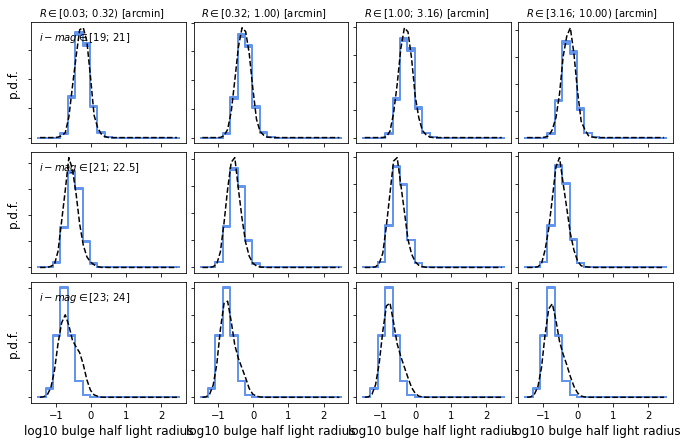

In [44]:
fig, axarr = plt.subplots(nrows=3, ncols=4, figsize=(11.5, 7.), sharex=False, sharey=False)
fig.subplots_adjust(hspace=0.075, wspace=0.05)

bins_hist = np.linspace(-1.5, 2.5, 20)
cens_hist = bins_hist[:-1] + np.diff(bins_hist) / 2
bins_kde = np.linspace(-1.5, 2.5, 40)
cens = bins_kde[:-1] + np.diff(bins_kde) / 2

for ax in axarr[0]:
    ax.set_xticklabels([])
for ax in axarr[1]:
    ax.set_xticklabels([])    

for ax in axarr[:, 0]:
    ax.set_yticklabels([])
    
for ax in axarr[0, 1:]:
    ax.set_yticklabels([])
for ax in axarr[1, 1:]:
    ax.set_yticklabels([])
for ax in axarr[2, 1:]:
    ax.set_yticklabels([])    
        
for ax in axarr[2]:
    ax.set_xlabel("log10 bulge half light radius", fontsize=12)
for ax in axarr[:, 0]:
    ax.set_ylabel("p.d.f.", fontsize=12)
    
col = "SIZE_BULGE" 
magcol = "MAG_I"
rcol = "LOGR"

r_lims_all = [(-1.5, -0.5), (-0.5, 0.), (0, 0.5), (0.5, 1.0)]

# ####################################################################################################
mag_lims = (19., 21.)
for rbin in np.arange(4):
    ax = axarr[0, rbin]

    r_lims = r_lims_all[rbin]
    sample = _deep_smc_settings["container"].data
#     csample = csamples[rbin]
#     rsample = rsamples[rbin]

    ax.text(0.05, 1.05,"$R \in[{:.2f};\,{:.2f})$ [arcmin]".format(10**r_lims[0], 10**r_lims[1]),
            transform=ax.transAxes, fontsize=10)  
        

#     ctab = _dc2_wide_cr_settings_clust["container"].data.copy()
#     ii = ((ctab[magcol] > mag_lims[0]) & (ctab[magcol] < mag_lims[1]) &
#           (ctab[rcol] > r_lims[0]) & (ctab[rcol] < r_lims[1]))
#     counts = np.histogram(ctab[ii][col], bins=bins_hist)[0]    
#     c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
#     c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
#     counts = counts / (counts * np.diff(bins_hist)).sum()
#     edges, v16 = tohist(bins_hist, c16)
#     edges, v84 = tohist(bins_hist, c84)
#     ax.fill_between(edges, v16, v84, color="orange", label="DC2", lw=2, alpha=0.6)    
    
    
    ii = (sample[magcol] > mag_lims[0]) & (sample[magcol] < mag_lims[1])
    counts = np.histogram(sample[ii][col], bins=bins_hist)[0]
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="cornflowerblue", lw=2, label="field")     
    
#     ctab = y3_ctab
#     ii = ((ctab[magcol] > mag_lims[0]) & (ctab[magcol] < mag_lims[1]) &
#           (ctab[rcol] > r_lims[0]) & (ctab[rcol] < r_lims[1]))
#     counts = np.histogram(ctab[ii][col], bins=bins_hist)[0]    
#     c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
#     c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
#     counts = counts / (counts * np.diff(bins_hist)).sum()
#     edges, v16 = tohist(bins_hist, c16)
#     edges, v84 = tohist(bins_hist, c84)
#     ax.fill_between(edges, v16, v84, color="magenta", label="Y3", lw=2, alpha=0.6)        


    
    allsample = hybrid_allsamples[rbin]
    ii = ((allsample[magcol] > mag_lims[0]) & (allsample[magcol] < mag_lims[1]) &
          (allsample[rcol] > r_lims[0]) & (allsample[rcol] < r_lims[1]))
    counts = np.histogram(allsample[ii][col], bins=bins_kde, density=True)[0]    
    ax.plot(cens, counts, ls="--", color="black", lw=1.5, label="LOS model")   
    
#     allsample = y3_allsamples[rbin]
#     ii = ((allsample[magcol] > mag_lims[0]) & (allsample[magcol] < mag_lims[1]) &
#           (allsample[rcol] > r_lims[0]) & (allsample[rcol] < r_lims[1]))
#     counts = np.histogram(allsample[ii][col], bins=bins_kde, density=True)[0]    
#     ax.plot(cens, counts, ls="--", color="red", lw=1.5, label="LOS model")         
    
# # ####################################################################################################
mag_lims = (21., 22.5)
for rbin in np.arange(4):
    ax = axarr[1, rbin]

    r_lims = r_lims_all[rbin]
    sample = _deep_smc_settings["container"].data
#     csample = csamples[rbin]
#     rsample = rsamples[rbin]

#     ctab = _dc2_wide_cr_settings_clust["container"].data.copy()
#     ii = ((ctab[magcol] > mag_lims[0]) & (ctab[magcol] < mag_lims[1]) &
#           (ctab[rcol] > r_lims[0]) & (ctab[rcol] < r_lims[1]))
#     counts = np.histogram(ctab[ii][col], bins=bins_hist)[0]    
#     c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
#     c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
#     counts = counts / (counts * np.diff(bins_hist)).sum()
#     edges, v16 = tohist(bins_hist, c16)
#     edges, v84 = tohist(bins_hist, c84)
#     ax.fill_between(edges, v16, v84, color="orange", label="DC2 LOS", lw=2, alpha=0.6)  
    
    ii = (sample[magcol] > mag_lims[0]) & (sample[magcol] < mag_lims[1])
    counts = np.histogram(sample[ii][col], bins=bins_hist)[0]
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="cornflowerblue", lw=2, label="field")     
    
    allsample = hybrid_allsamples[rbin]
    ii = ((allsample[magcol] > mag_lims[0]) & (allsample[magcol] < mag_lims[1]) &
          (allsample[rcol] > r_lims[0]) & (allsample[rcol] < r_lims[1]))
    counts = np.histogram(allsample[ii][col], bins=bins_kde, density=True)[0]    
    ax.plot(cens, counts, ls="--", color="black", lw=1.5, label="DC2 model")       
        
#     ctab = y3_ctab
#     ii = ((ctab[magcol] > mag_lims[0]) & (ctab[magcol] < mag_lims[1]) &
#           (ctab[rcol] > r_lims[0]) & (ctab[rcol] < r_lims[1]))
#     counts = np.histogram(ctab[ii][col], bins=bins_hist)[0]    
#     c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
#     c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
#     counts = counts / (counts * np.diff(bins_hist)).sum()
#     edges, v16 = tohist(bins_hist, c16)
#     edges, v84 = tohist(bins_hist, c84)
#     ax.fill_between(edges, v16, v84, color="magenta", label="Y3 LOS", lw=2, alpha=0.6)        
        

#     allsample = y3_allsamples[rbin]
#     ii = ((allsample[magcol] > mag_lims[0]) & (allsample[magcol] < mag_lims[1]) &
#           (allsample[rcol] > r_lims[0]) & (allsample[rcol] < r_lims[1]))
#     counts = np.histogram(allsample[ii][col], bins=bins_kde, density=True)[0]    
#     ax.plot(cens, counts, ls="--", color="red", lw=1.5, label="Y3 model")            
#     handles, labels = ax.get_legend_handles_labels()    

# # ####################################################################################################
mag_lims = (23., 24)
for rbin in np.arange(4):
    ax = axarr[2, rbin]

    r_lims = r_lims_all[rbin]
    sample = _deep_smc_settings["container"].data
#     csample = csamples[rbin]
#     rsample = rsamples[rbin]
   
    
#     ctab = _dc2_wide_cr_settings_clust["container"].data.copy()
#     ii = ((ctab[magcol] > mag_lims[0]) & (ctab[magcol] < mag_lims[1]) &
#           (ctab[rcol] > r_lims[0]) & (ctab[rcol] < r_lims[1]))
#     counts = np.histogram(ctab[ii][col], bins=bins_hist)[0]    
#     c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
#     c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
#     counts = counts / (counts * np.diff(bins_hist)).sum()
#     edges, v16 = tohist(bins_hist, c16)
#     edges, v84 = tohist(bins_hist, c84)
#     ax.fill_between(edges, v16, v84, color="orange", label="Cluster LOS", lw=2, alpha=0.6)    
    
    ii = (sample[magcol] > mag_lims[0]) & (sample[magcol] < mag_lims[1])
    counts = np.histogram(sample[ii][col], bins=bins_hist)[0]
    c16 = (counts - np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    c84 = (counts + np.sqrt(counts)) / (counts * np.diff(bins_hist)).sum()
    counts = counts / (counts * np.diff(bins_hist)).sum()
    edges, v16 = tohist(bins_hist, c16)
    edges, v84 = tohist(bins_hist, c84)
    ax.fill_between(edges, v16, v84, color="cornflowerblue", lw=2, label="field")         
    
    allsample = hybrid_allsamples[rbin]
    ii = ((allsample[magcol] > mag_lims[0]) & (allsample[magcol] < mag_lims[1]) &
          (allsample[rcol] > r_lims[0]) & (allsample[rcol] < r_lims[1]))
    counts = np.histogram(allsample[ii][col], bins=bins_kde, density=True)[0]    
    ax.plot(cens, counts, ls="--", color="black", lw=1.5, label="LOS model")     
    
#     allsample = y3_allsamples[rbin]
#     ii = ((allsample[magcol] > mag_lims[0]) & (allsample[magcol] < mag_lims[1]) &
#           (allsample[rcol] > r_lims[0]) & (allsample[rcol] < r_lims[1]))
#     counts = np.histogram(allsample[ii][col], bins=bins_kde, density=True)[0]    
#     ax.plot(cens, counts, ls="--", color="red", lw=1.5, label="LOS model")        

    
fs = 10

# axarr[2, 3].legend(loc=3, fontsize=fs, handles=handles, labels=labels)    
    

# axarr[2, 0].text(0.05, 0.72, "Depth Extrapolation", transform=axarr[2, 0].transAxes, fontsize=fs)
# axarr[0, 0].text(0.05, 0.63, "$\lambda\in[30;\,60)$", transform=axarr[0, 0].transAxes, fontsize=fs)
# axarr[0, 0].text(0.05, 0.51, "$z\in[0.3;\,0.35)$", transform=axarr[0, 0].transAxes, fontsize=fs)

axarr[0, 0].text(0.05, 0.85, "$i-mag\in[19;\, 21]$", transform=axarr[0, 0].transAxes, fontsize=fs)
axarr[1, 0].text(0.05, 0.85, "$i-mag\in[21;\, 22.5]$", transform=axarr[1, 0].transAxes, fontsize=fs)
axarr[2, 0].text(0.05, 0.85, "$i-mag\in[23;\, 24]$ ", transform=axarr[2, 0].transAxes, fontsize=fs)
# axarr[2, 0].text(0.05, 0.73, "Depth Extrapolation".upper(), transform=axarr[2, 0].transAxes, fontsize=fs, color="red")
# fig.text(0.13, 0.95, "DC2 redmapper clusters Emulator model", fontsize=14)
# fig.savefig("Hybrid-DC2xY3-ALPHA_LOWZ_decoupled_g-r-color_magnitude_slices_radial_v01.png", dpi=300, bbox_inches="tight")